In [1]:
import sys
sys.path.append('../../..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import xarray as xr
import random as rd
import platform
import adamod
import torch
import torch.nn.functional as F


from torch.utils.data import DataLoader
from collections import OrderedDict
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from utils.dataset import NCDFDatasets
from utils.trainer import Tester
from utils.trainer import Trainer
from datetime import datetime
from evonorm import EvoNorm3D

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()
device

device(type='cuda', index=0)

In [4]:
batch_size = 25
validation_split = 0.2
test_split = 0.2
dropout_rate = 0.2
hidden_size = 32*32
mogrify_rounds = 5
param = {'encoder_layer_size': 3, 'decoder_layer_size': 3, 'kernel_size': 5, 'filter_size': 32}
weights = [0.9, 0.1]

In [5]:
import xarray as xr
data_path = '/content/drive/My Drive/Colab Notebooks/dataset-ucar-1979-2015-seq5-ystep5.nc'
dataset = xr.open_dataset(data_path)
print(dataset)

<xarray.Dataset>
Dimensions:  (channel: 1, lat: 32, lon: 32, sample: 54047, time: 5)
Coordinates:
  * lat      (lat) int32 -54 -52 -50 -48 -46 -44 -42 -40 ... -6 -4 -2 0 2 4 6 8
  * lon      (lon) int32 278 280 282 284 286 288 290 ... 330 332 334 336 338 340
Dimensions without coordinates: channel, sample, time
Data variables:
    x        (sample, time, lat, lon, channel) float32 ...
    y        (sample, time, lat, lon, channel) float32 ...
Attributes:
    description:  The variables have air temperature values and are separable...


In [6]:
#In these experiments y has dimensions [batch, channel, lat, lon] as opposed to [batch, channel, time, lat, lon] to
#avoid dimension conflict with conv kernels
data = NCDFDatasets(dataset, val_split = 0.2, test_split = 0.2,  data_type='Reconstruction')
train_data = data.get_train()
val_data = data.get_val()
test_data = data.get_test()

In [7]:
print("-----Train-----")
print("X : ", train_data.x.shape)
print("Y : ", train_data.y.shape)
print("Removed : ", train_data.removed.shape)
print("-----Val-----")
print("X : ", val_data.x.shape)
print("Y : ", val_data.y.shape)
print("Removed : ", val_data.removed.shape)
print("-----Test-----")
print("X : ", test_data.x.shape)
print("Y : ", test_data.y.shape)
print("Removed : ", test_data.removed.shape)

-----Train-----
X :  torch.Size([32429, 1, 10, 32, 32])
Y :  torch.Size([32429, 1, 10, 32, 32])
Removed :  torch.Size([32429])
-----Val-----
X :  torch.Size([10809, 1, 10, 32, 32])
Y :  torch.Size([10809, 1, 10, 32, 32])
Removed :  torch.Size([10809])
-----Test-----
X :  torch.Size([10809, 1, 10, 32, 32])
Y :  torch.Size([10809, 1, 10, 32, 32])
Removed :  torch.Size([10809])


In [8]:
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark = False

def init_seed(seed):
    np.random.seed(seed)
    
init_seed = init_seed(seed)

In [9]:
params = {'batch_size': batch_size,
          'num_workers': 4,
          'worker_init_fn': init_seed}

train_loader = DataLoader(dataset=train_data, shuffle=True, **params)
val_loader = DataLoader(dataset=val_data, shuffle=False, **params)
test_loader = DataLoader(dataset=test_data, shuffle=False, **params)

In [10]:
class Mish(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [11]:
class CustomConv3d(torch.nn.Conv3d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1,
                 bias=False, padding_mode='zeros', weight=None):
        super().__init__(in_channels, out_channels, kernel_size, stride=stride,
                 padding=padding, dilation=dilation,
                 bias=bias, padding_mode=padding_mode)
        
    def forward(self,input, weight=None):
        if (weight is not None):
            return F.conv3d(input, weight.permute(1,0,2,3,4), self.bias, self.stride,
                        self.padding, self.dilation)
        else:
            return F.conv3d(input, self.weight, self.bias, self.stride,
                        self.padding, self.dilation)

In [12]:
class EncoderCNN(torch.nn.Module):
    def __init__(self, layer_size, kernel_size, initial_out_channels, initial_in_channels, device):
        super(EncoderCNN, self).__init__()
        self.device = device
        self.layer_size = layer_size
        self.conv_layers = torch.nn.ModuleList()
        #self.mish_layers = torch.nn.ModuleList()
        self.bn_layers = torch.nn.ModuleList()
        self.decode_bn_layers = torch.nn.ModuleList()
        #self.dropout_layers = torch.nn.ModuleList()
        
        self.kernel_size = [1, kernel_size, kernel_size]
        self.padding = [0, kernel_size // 2, kernel_size // 2]
        
        in_channels = initial_in_channels
        out_channels = initial_out_channels
        for i in range(self.layer_size):
            self.conv_layers.append(CustomConv3d(in_channels = in_channels, out_channels = out_channels,
                                                padding = self.padding, kernel_size = self.kernel_size))
            #self.mish_layers.append(Mish())
            self.bn_layers.append(EvoNorm3D(out_channels, version = 'B0_3D'))
            self.decode_bn_layers.append(EvoNorm3D(out_channels, version = 'B0_3D'))
            #self.dropout_layers.append(torch.nn.Dropout(dropout_rate))
            in_channels = out_channels
        self.conv_reduce = CustomConv3d(in_channels = in_channels, out_channels = 1,
                                                kernel_size = 1)
            
            
    def forward(self, x, decode=False, x_rev=None):
        if (decode):
            x = self.conv_reduce(x, self.conv_reduce.weight)
            if (x_rev is not None):
              x_rev = self.conv_reduce(x_rev, self.conv_reduce.weight)
              x = (x + x_rev) / 2
            for i in range(self.layer_size-1, -1, -1):
                x = self.decode_bn_layers[i](x)
                #x = self.dropout_layers[i](x)
                x = self.conv_layers[i](x, self.conv_layers[i].weight)
        else:
            for i in range(self.layer_size):
                x = self.conv_layers[i](x)
                x = self.bn_layers[i](x)
                #x = self.dropout_layers[i](x)
            x = self.conv_reduce(x)
        return x

In [13]:
class STModel(torch.nn.Module):
    def __init__(self, encoder_layer_size, kernel_size, out_channels, in_channels, input_width, input_height, hidden_size
                 , device):
        super(STModel, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.encoder = EncoderCNN(layer_size = encoder_layer_size, kernel_size = kernel_size,
                                initial_out_channels = out_channels,
                                initial_in_channels = in_channels, device=device)
        #self.recurrent_encoder = torch.nn.LSTM(input_width*input_height, self.hidden_size, batch_first=True, bidirectional = True);
        self.recurrent_forward = torch.nn.LSTMCell(input_width*input_height, hidden_size);
        self.recurrent_backward = torch.nn.LSTMCell(input_width*input_height, hidden_size);
       
        
    def forward(self, x, states_fwd, states_bckwd, removed):
        batch, channel, time, lat, lon = x.size()
        x = self.encoder(x)
        
        x = x.squeeze().view(batch, time, -1)

        '''for b in range(x.shape[0]):
          if (removed[b] != 0 and removed[b] != 9):
            x[b,removed[b],:] = (x[b,removed[b]-1,:] + x[b,removed[b]+1, :]) / 2
          elif (removed[b] == 0):
            x[b,removed[b],:] = x[b,removed[b]+1,:]
          else:
            x[b,removed[b],:] = x[b,removed[b]-1,:]'''

        x_rev = torch.flip(x, [1])
        h_fwd = states_fwd[0]
        c_fwd = states_fwd[1]
        h_bckwd = states_bckwd[0]
        c_bckwd = states_bckwd[1]
        
        outputs_fwd = torch.zeros(batch, time, lat*lon, device=self.device)
        outputs_bckwd = torch.zeros(batch, time, lat*lon, device=self.device)

        for i in range(time):
            in_x = x[:,i,:].clone()
            removed_batches = ((removed == i).nonzero().flatten())
            in_x[removed_batches, :] = h_fwd[removed_batches, :]
            h_fwd, c_fwd = self.recurrent_forward(in_x,(h_fwd,c_fwd))
            outputs_fwd[:,i,:] = h_fwd
            
            in_x_rev = x_rev[:,i,:].clone()
            removed_batches_bckwd = ((removed == (time-1-i)).nonzero().flatten())
            in_x_rev[removed_batches_bckwd, :] = h_bckwd[removed_batches_bckwd, :].clone()
            h_bckwd, c_bckwd = self.recurrent_backward(in_x_rev, (h_bckwd,c_bckwd))
            outputs_bckwd[:,i,:] = h_bckwd

        outputs_bckwd = torch.flip(outputs_bckwd, [1])
            
        #outputs = (outputs_fwd + outputs_bckwd) / 2

        x = outputs_fwd.contiguous().view(batch, channel, time, lat, lon)
        #x = outputs.contiguous().view(batch, channel, time, lat, lon)
        x_rev = outputs_bckwd.contiguous().view(batch, channel, time, lat, lon)
        x = self.encoder(x, decode=True, x_rev = x_rev)
        return x
        

In [22]:
class WeightedRMSELoss(torch.nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        self.eps = eps
        
    def forward(self,y,yhat, removed):
        #y : 25 x ch x time x lat x lon
        #removed : 25
        batch, ch, time, lat, lon = yhat.shape
        cumulative_loss = 0
        for i in range(batch):
            cumulative_loss += self.mse(y[i,:,removed[i],:,:],  yhat[i,:,removed[i],:,:])
        return torch.sqrt((cumulative_loss / (batch))+ self.eps)
    '''def forward(self,yhat,y, removed):
        #y : 25 x ch x time x lat x lon
        #removed : 25
        batch, ch, time, lat, lon = yhat.shape
        cumulative_loss = 0
        for i in range(batch):
            for j in range(time):
                weight = weights[0] if removed[i] == j else (weights[1]/(time-1))
                cumulative_loss += self.mse(yhat[i,:,j,:,:], y[i,:,j,:,:]) * weight
        return torch.sqrt((cumulative_loss / (batch))+ self.eps)'''


In [23]:
model = STModel(encoder_layer_size = param['encoder_layer_size'], kernel_size = param['kernel_size'], out_channels = param['filter_size'],
                in_channels = train_data.x.shape[1], input_width = train_data.x.shape[3], 
                input_height = train_data.x.shape[4], hidden_size = hidden_size, device=device).to(device)
criterion = WeightedRMSELoss()
#optimizer_params = {'lr': 0.001}
#optimizer = torch.optim.Adam(net.parameters(), **optimizer_params)
opt_params = {'lr': 0.001, 
              'beta3': 0.999}
optimizer = adamod.AdaMod(model.parameters(), **opt_params)
model

STModel(
  (encoder): EncoderCNN(
    (conv_layers): ModuleList(
      (0): CustomConv3d(1, 32, kernel_size=[1, 5, 5], stride=(1, 1, 1), padding=[0, 2, 2], bias=False)
      (1): CustomConv3d(32, 32, kernel_size=[1, 5, 5], stride=(1, 1, 1), padding=[0, 2, 2], bias=False)
      (2): CustomConv3d(32, 32, kernel_size=[1, 5, 5], stride=(1, 1, 1), padding=[0, 2, 2], bias=False)
    )
    (bn_layers): ModuleList(
      (0): EvoNorm3D()
      (1): EvoNorm3D()
      (2): EvoNorm3D()
    )
    (decode_bn_layers): ModuleList(
      (0): EvoNorm3D()
      (1): EvoNorm3D()
      (2): EvoNorm3D()
    )
    (conv_reduce): CustomConv3d(32, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
  )
  (recurrent_forward): LSTMCell(1024, 1024)
  (recurrent_backward): LSTMCell(1024, 1024)
)

In [24]:
model_path = os.path.join('ST-RFD-EvoNormB03D' + '_' + datetime.now().strftime('m%md%d-h%Hm%Ms%S') + '.pth.tar')
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, 100, device, model_path, recurrent_model= True, is_reconstruction=True)


In [25]:
train_losses, val_losses = trainer.train_evaluate()

Train - Epoch 0, Epoch Loss: 2.195483
Val Avg. Loss: 1.980688
=> Saving a new best
Train - Epoch 1, Epoch Loss: 1.306051
Val Avg. Loss: 1.227937
=> Saving a new best
Train - Epoch 2, Epoch Loss: 1.179852
Val Avg. Loss: 1.439607
Train - Epoch 3, Epoch Loss: 1.111811
Val Avg. Loss: 1.148891
=> Saving a new best
Train - Epoch 4, Epoch Loss: 1.066794
Val Avg. Loss: 1.155447
Train - Epoch 5, Epoch Loss: 1.026324
Val Avg. Loss: 1.105634
=> Saving a new best
Train - Epoch 6, Epoch Loss: 0.996594
Val Avg. Loss: 1.229730
Train - Epoch 7, Epoch Loss: 0.970287
Val Avg. Loss: 1.058404
=> Saving a new best
Train - Epoch 8, Epoch Loss: 0.944023
Val Avg. Loss: 1.015665
=> Saving a new best
Train - Epoch 9, Epoch Loss: 0.925818
Val Avg. Loss: 1.190120
Train - Epoch 10, Epoch Loss: 0.904199
Val Avg. Loss: 1.007099
=> Saving a new best
Train - Epoch 11, Epoch Loss: 0.887794
Val Avg. Loss: 1.015952
Train - Epoch 12, Epoch Loss: 0.868210
Val Avg. Loss: 1.126193
Train - Epoch 13, Epoch Loss: 0.851508
Val A

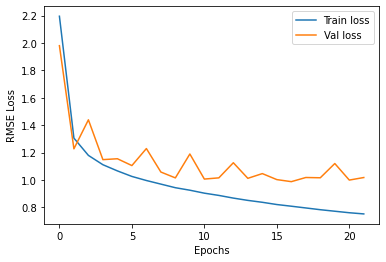

In [30]:
epochs = np.arange(1,len(val_losses))
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Train loss', 'Val loss'], loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("RMSE Loss")
plt.show()

In [ ]:

model, optimizer, epoch, loss = trainer.load_model()
batch_test_loss = 0.0
model.eval()
with torch.no_grad():
    for i, (x, y, removed) in enumerate(test_loader):
        x,y,removed = x.to(device), y.to(device), removed.to(device)
        output = model(x)
        loss = criterion(output, y, removed)
        batch_test_loss += loss.detach().item()
test_loss = batch_test_loss/len(test_loader)
loss_type = type(criterion).__name__
print(f'STConvS2S {loss_type}: {test_loss:.4f}')

In [26]:
class RMSELoss(torch.nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [27]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np

criterion_mae = torch.nn.L1Loss()
criterion_rmse = RMSELoss()
def report_regression_results(y_true, y_pred):
    # Print multiple regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    adjusted_r2 =  1.0 - ( mse / y_true.var() )
    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('Adjusted r2: ', round(adjusted_r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    # save a plot with the residuals
    plt.scatter(y_pred,(y_true - y_pred),edgecolors='black')
    plt.title('Fitted vs. residuals plot')
    plt.xlabel("Fitted")
    plt.ylabel("Residual")
    plt.show()
    f.savefig("report-experiment1.pdf", bbox_inches='tight')
    
def report_explained_variance(y_true, y_pred):
    batch, ch, lat, lon = y_true.shape
    explained_variance = 0
    for i in range(batch):
        explained_variance += metrics.explained_variance_score(y_true[i,0,:,:], y_pred[i,0,:,:])
    return explained_variance / (batch)

def report_r2(y_true, y_pred):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    mse = metrics.mean_squared_error(y_true, y_pred) 
    r2 = metrics.r2_score(y_true, y_pred)
    ar2 =  1.0 - ( mse / y_true.var() )
    return r2, ar2

def report_losses(y_true, y_pred):
    mae = criterion_mae(y_true, y_pred)
    rmse = criterion_rmse(y_true, y_pred)
    return mae, rmse

def report_metrics(y_true, y_pred, removed):
    batch, ch, time, lat, lon = y_true.shape
    r2 = 0.0
    ar2 = 0.0
    mae = 0.0
    rmse = 0.0
    for i in range(batch):
        v1,v2 = report_r2(y_true[i,0,removed[i],:,:], y_pred[i,0,removed[i],:,:])
        r2 += v1
        ar2 += v2
        v1, v2 = report_losses(y_true[i,0,removed[i],:,:], y_pred[i,0,removed[i],:,:])
        mae += v1
        rmse += v2
    r2 = r2/(batch)
    ar2 = ar2/(batch)
    mae = mae/batch
    rmse = rmse/batch
    return mae, rmse, r2, ar2

def plot_residual_fitted(y_true, y_pred):
    plt.scatter(y_pred,(y_true - y_pred), alpha=0.5)
    plt.title('STConvS2S')
    plt.xlabel("Fitted")
    plt.ylabel("Residual")
    plt.show()

In [28]:
def init_hidden(batch_size, hidden_size, device):
		h = torch.zeros(batch_size,hidden_size, device=device)
		return (h,h)

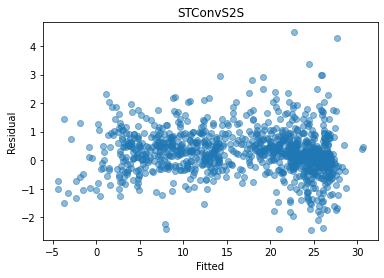

MAE: 0.6988
RMSE: 0.9717
Explained variance:  0.0
r2:  0.9825
ar2:  0.9847


In [29]:
model, optimizer, epoch, loss = trainer.load_model()
batch_test_loss_mae = 0.0
batch_test_loss_rmse = 0.0
batch_explained_variance = 0.0
batch_r2 = 0.0
batch_ar2 = 0.0
model.eval()
y_true = None
with torch.no_grad():
    for i, (x, y, removed) in enumerate(test_loader):
        x,y,removed = x.to(device), y.to(device), removed.to(device)
        states_fwd = init_hidden(x.size()[0], x.size()[3]*x.size()[4], device)
        states_bckwd = init_hidden(x.size()[0], x.size()[3]*x.size()[4], device)
        output = model(x, states_fwd, states_bckwd, removed)
        loss_mae, loss_rmse, r2, ar2 = report_metrics(y, output, removed)
        if (i == 0):
            plot_residual_fitted(y[0,0,removed[i],:,:].cpu(), output[0,0,removed[i],:,:].cpu())
        batch_test_loss_mae += loss_mae.detach().item()
        batch_test_loss_rmse += loss_rmse.detach().item()
        batch_r2 += r2
        batch_ar2 += ar2
        
test_loss_mae = batch_test_loss_mae/len(test_loader)
test_loss_rmse = batch_test_loss_rmse/len(test_loader)
explained_variance = batch_explained_variance/len(test_loader)
r2 = batch_r2/len(test_loader)
ar2 = batch_ar2/len(test_loader)
print(f'MAE: {test_loss_mae:.4f}')
print(f'RMSE: {test_loss_rmse:.4f}')
print('Explained variance: ', round(explained_variance,4))
print('r2: ', round(r2,4))
print('ar2: ', round(ar2,4))